In [ ]:
pip install -U --pre segmentation-models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab/archive2.zip'

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/liverdata')

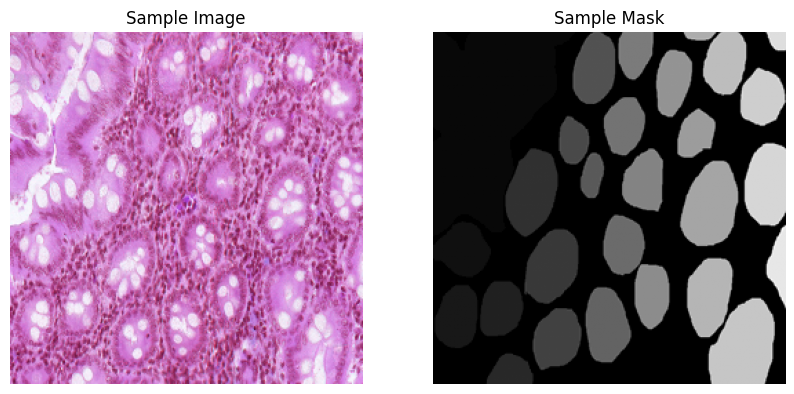

171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.2490 - loss: 0.7551 - mean_io_u: 1.0000 
Epoch 1: val_loss improved from inf to 1475416.62500, saving model to T1_RES101_Unet_best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 461s 42s/step - accuracy: 0.2600 - loss: 0.7452 - mean_io_u: 1.0000 - val_accuracy: 0.0281 - val_loss: 1475416.6250 - val_mean_io_u: 0.0285
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.4900 - loss: 0.3949 - mean_io_u: 1.0000 
Epoch 2: val_loss did not improve from 1475416.62500
9/9 ━━━━━━━━━━━━━━━━━━━━ 449s 43s/step - accuracy: 0.4897 - loss: 0.3919 - mean_io_u: 1.0000 - val_accuracy: 0.0199 - val_loss: 12787936.0000 - val_mean_io_u: 0.0185
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.4777 - loss: 0.2593 - mean_io_u: 1.0000 
Epoch 3: val_loss improved from 1475416.62500 to 15433.31641, saving model to T1_RES101_Unet_best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 408s 46s/step 

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import segmentation_models as sm  # Make sure this is installed: pip install segmentation-models

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Model setup
BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Dataset path
data_dir = '/content/liverdata/Warwick_QU_Dataset/'
images = []
masks = []

# Load image-mask pairs
for filename in os.listdir(data_dir):
    if filename.endswith('.bmp') and '_anno' not in filename:
        image_path = os.path.join(data_dir, filename)
        mask_name = filename.replace('.bmp', '_anno.bmp')
        mask_path = os.path.join(data_dir, mask_name)


        if os.path.exists(mask_path):
            # Load image (RGB)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is not None:
                img_resized = cv2.resize(img, (256, 256))
                image = img_to_array(img_resized) / 255.0
                images.append(image)

            # Load mask (Grayscale → 1 channel)
            with Image.open(mask_path) as msk:
                msk_resized = msk.resize((256, 256), Image.LANCZOS)
                msk_gray = msk_resized.convert('L')  # Convert to grayscale
                mask = img_to_array(msk_gray) / 255.0
                mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
                masks.append(mask)

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Display a sample image and mask
if len(images) > 0:
    sample_index = min(47, len(images) - 1)
    sample_image = images[sample_index]
    sample_mask = masks[sample_index]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image.astype('float32'))
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title('Sample Mask')
    plt.axis('off')
    plt.show()
else:
    print("No valid image/mask pairs found.")
    exit()

# Split and preprocess
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
x_train = preprocess_input(train_images)
x_val = preprocess_input(val_images)

# Define and compile model
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2), 'accuracy'])

# Callbacks
tensorboard_callback = TensorBoard(log_dir='t1_Res101_Unet_logs')
model_checkpoint_callback = ModelCheckpoint('T1_RES101_Unet_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model.fit(
    x=train_images,
    y=train_masks,
    batch_size=16,
    epochs=100,
    validation_data=(val_images, val_masks),
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)


In [ ]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Define the path to the data directory
data_dir = '/kaggle/input/liverdata/data/'

# Initialize lists to store images and masks
images = []
masks = []


# Loop through the subdirectories
for subdir in os.listdir(data_dir):
    if subdir.startswith('image_'):
        # Load the imaging and segmentation images
        image_path = os.path.join(data_dir, subdir, 'imaging.png')
        mask_path = os.path.join(data_dir, subdir, 'segmentation.png')

        # Open the image with OpenCV, equalize its histogram, and convert it to an array
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        #img_equalized = cv2.equalizeHist(img)
        img_resized = cv2.resize(img, (256, 256))
        image = img_to_array(img_resized) / 255.0 # normalize pixel values
        images.append(image)

        # Open the mask with Pillow, resize it, and convert it to an array
        with Image.open(mask_path) as img:
            img_resized = img.resize((256, 256), Image.LANCZOS)
            mask = img_to_array(img_resized) / 255.0 # normalize pixel values
            #mask = np.expand_dims(mask, axis=-1) # add channel dimension
            masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Display one sample image and its corresponding mask
sample_index = 47 # Change this to display a different sample
sample_image = images[sample_index]
sample_mask = masks[sample_index]
# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title('Sample Image')
plt.axis('off')

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title('Sample Mask')
plt.axis('off')

plt.show()
# Split the data into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
# preprocess input
x_train = preprocess_input(train_images)
x_val = preprocess_input(val_images)

# define model
model = sm.Unet(BACKBONE,classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile(
    'Adam',loss='binary_crossentropy',
    #loss=sm.losses.bce_jaccard_loss,
    metrics=[MeanIoU(num_classes=1),'accuracy']
)
tensorboard_callback = TensorBoard(log_dir='t1_Res101_Unet_logs')
#early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_callback = ModelCheckpoint('T1_RES101_Unet_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history=model.fit(
   x=train_images,
   y=train_masks,
   batch_size=16,
   epochs=100,
   validation_data=(val_images, val_masks), callbacks=[tensorboard_callback, model_checkpoint_callback]
)


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()


In [ ]:
import cv2
import numpy as np
import segmentation_models as sm
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained model
BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Assuming you have already defined your model architecture as 'model'
# For example, if you're using a Unet model with a ResNet34 backbone
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.load_weights('/kaggle/working/T1_RES101_Unet_best_model.keras')
# Define the preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (256, 256))
    image = img_to_array(img_resized) / 255.0
    return image

# Preprocess the test image
test_image_path = '/kaggle/input/liverdata/data/image_177/imaging.png'
test_image = preprocess_image(test_image_path)

# Ensure the image has the correct shape and add the batch dimension
test_image = np.expand_dims(test_image, axis=0) # Now the shape should be (1, 512, 512, 3)

# Perform inference
predictions = model.predict(test_image)

# Post-process the predictions if necessary
# For binary segmentation, you might want to apply a threshold
predictions = (predictions > 0.5).astype(np.uint8)

# Visualize the results
# Assuming you have the corresponding mask for the test image
test_mask_path = '/kaggle/input/liverdata/data/image_177/segmentation.png'
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (256, 256)) / 255.0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(test_image[0])
axes[0].set_title('Original Image')

# Ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')

# Predicted mask
axes[2].imshow(predictions[0], cmap='gray')
axes[2].set_title('Predicted Mask')

plt.show()

